# Modelos Estatísticos Clássicos

In [6]:
#@title Importando as bibliotecas

# Libs básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

#SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pathlib import Path

# **ARIMA**

# **Teste 1**

In [7]:
#@title 1. Leitura e preparação dos dados

sp500 = pd.read_csv('/content/SP500.csv', parse_dates=['Date'])
sp500.sort_values('Date', inplace=True)
sp500.set_index('Date', inplace=True)
close_prices = sp500['Close']

In [8]:
#@title 2. Divisão treino/teste

split = int(len(close_prices) * 0.8)
train = close_prices[:split]
test = close_prices[split:]

In [9]:
#@title 3. Ajuste do modelo SARIMA apenas no treino

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
#@title 4. Previsão para o período de teste

forecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
#@title 5. Geração de sinais de trading no teste

signals = []
for i in range(len(test)):
    if forecast.iloc[i] > test.iloc[i-1] if i > 0 else train.iloc[-1]:
        signals.append('buy')
    elif forecast.iloc[i] < test.iloc[i-1] if i > 0 else train.iloc[-1]:
        signals.append('sell')
    else:
        signals.append('hold')
test_df = pd.DataFrame({'Close': test, 'Forecast': forecast, 'Signal': signals}, index=test.index)

In [12]:
#@title 6. Simulação de backtesting no teste

capital = 10000
position = 0
entry_price = 0
profits = []
trades = []
for i in range(len(test_df)):
    signal = test_df['Signal'].iloc[i]
    price = test_df['Close'].iloc[i]
    if signal == 'buy' and position == 0:
        position = 1
        entry_price = price
        trades.append('buy')
    elif signal == 'sell' and position == 1:
        profit = price - entry_price
        capital += profit
        profits.append(profit)
        position = 0
        trades.append('sell')
    else:
        trades.append('hold')
test_df['Trade'] = trades

In [13]:
#@title 7. Cálculo das métricas no teste

num_trades = trades.count('buy')
num_wins = sum([1 for p in profits if p > 0])
num_losses = sum([1 for p in profits if p <= 0])
percent_wins = num_wins / num_trades * 100 if num_trades > 0 else 0
percent_losses = num_losses / num_trades * 100 if num_trades > 0 else 0
lucro_total = sum(profits)
taxa_acerto_buy = num_wins / num_trades * 100 if num_trades > 0 else 0

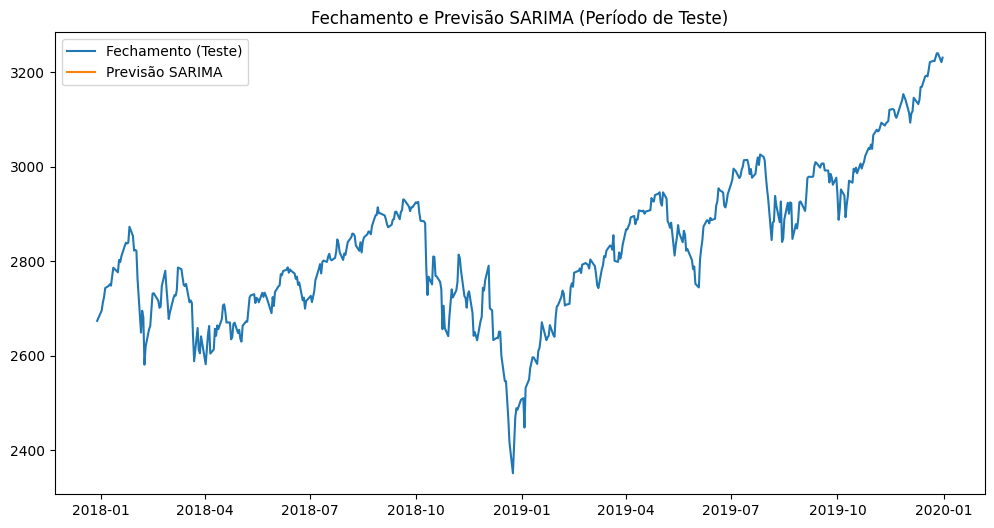

ValueError: Input contains NaN.

In [14]:
#@title 8. Relatórios visuais

plt.figure(figsize=(12,6))
plt.plot(test_df['Close'], label='Fechamento (Teste)')
plt.plot(test_df['Forecast'], label='Previsão SARIMA')
plt.legend()
plt.title('Fechamento e Previsão SARIMA (Período de Teste)')
plt.show()

# Cálculo do RMSE no teste
rmse = np.sqrt(mean_squared_error(test_df['Close'], test_df['Forecast']))
print(f'RMSE (Root Mean Squared Error) no teste: {rmse:.2f}')

print(f'Percentual de operações vencedoras: {percent_wins:.2f}%')
print(f'Percentual de operações perdedoras: {percent_losses:.2f}%')
print(f'Lucro Total: {lucro_total:.2f}')
print(f'Taxa de acerto (comprar): {taxa_acerto_buy:.2f}%')

# **Teste 2**

In [15]:
#@title 1. Leitura e preparação dos dados

sp500 = pd.read_csv('/content/SP500.csv', parse_dates=['Date'])
sp500.sort_values('Date', inplace=True)
sp500.set_index('Date', inplace=True)
sp500 = sp500.dropna(subset=['Close'])
close_prices = sp500['Close'].dropna()

In [16]:
#@title 2. Divisão treino/teste

split = int(len(close_prices) * 0.8)
train = close_prices[:split].dropna()
test = close_prices[split:].dropna()

In [17]:
#@title 3. Ajuste do modelo ARIMA apenas no treino

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
#@title 4. Previsão para o período de teste (rolling forecast)

history = list(train)
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])
predictions = pd.Series(predictions, index=test.index)

# Checagem de NaNs para depuração
print(f'NaNs em predictions: {pd.Series(predictions).isna().sum()}')
print(f'NaNs em test: {test.isna().sum()}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


NaNs em predictions: 0
NaNs em test: 0


In [ ]:
#@title 5. Geração de sinais de trading no teste

signals = []
for i in range(len(test)):
    prev_real = test.iloc[i-1] if i > 0 else train.iloc[-1]
    if predictions.iloc[i] > prev_real:
        signals.append('buy')
    elif predictions.iloc[i] < prev_real:
        signals.append('sell')
    else:
        signals.append('hold')
test_df = pd.DataFrame({'Close': test, 'Forecast': predictions, 'Signal': signals}, index=test.index)

In [ ]:
#@title 6. Simulação de backtesting no teste

capital = 10000
position = 0
entry_price = 0
profits = []
trades = []
for i in range(len(test_df)):
    signal = test_df['Signal'].iloc[i]
    price = test_df['Close'].iloc[i]
    if signal == 'buy' and position == 0:
        position = 1
        entry_price = price
        trades.append('buy')
    elif signal == 'sell' and position == 1:
        profit = price - entry_price
        capital += profit
        profits.append(profit)
        position = 0
        trades.append('sell')
    else:
        trades.append('hold')
test_df['Trade'] = trades

In [ ]:
#@title 7. Cálculo das métricas no teste

num_trades = trades.count('buy')
num_wins = sum([1 for p in profits if p > 0])
num_losses = sum([1 for p in profits if p <= 0])
percent_wins = num_wins / num_trades * 100 if num_trades > 0 else 0
percent_losses = num_losses / num_trades * 100 if num_trades > 0 else 0
lucro_total = sum(profits)
taxa_acerto_buy = num_wins / num_trades * 100 if num_trades > 0 else 0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

NaNs em predictions: 0
NaNs em test: 0


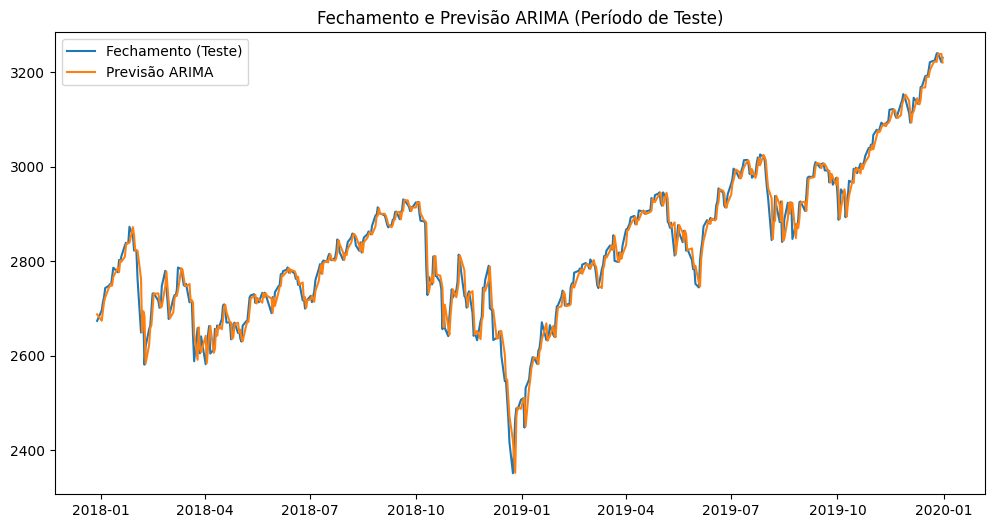

RMSE (Root Mean Squared Error) no teste: 25.80
Percentual de operações vencedoras: 60.00%
Percentual de operações perdedoras: 40.00%
Lucro Total: 150.51
Taxa de acerto (comprar): 60.00%


In [ ]:
#@title 8. Relatórios visuais

plt.figure(figsize=(12,6))
plt.plot(test_df['Close'], label='Fechamento (Teste)')
plt.plot(test_df['Forecast'], label='Previsão ARIMA')
plt.legend()
plt.title('Fechamento e Previsão ARIMA (Período de Teste)')
plt.show()

# Cálculo do RMSE no teste
rmse = np.sqrt(mean_squared_error(test_df['Close'], test_df['Forecast']))
print(f'RMSE (Root Mean Squared Error) no teste: {rmse:.2f}')

print(f'Percentual de operações vencedoras: {percent_wins:.2f}%')
print(f'Percentual de operações perdedoras: {percent_losses:.2f}%')
print(f'Lucro Total: {lucro_total:.2f}')
print(f'Taxa de acerto (comprar): {taxa_acerto_buy:.2f}%')

# **Teste 3**

In [ ]:
#@title 1. Leitura e preparação dos dados
sp500 = pd.read_csv('/content/SP500.csv', parse_dates=['Date'])
sp500.sort_values('Date', inplace=True)
sp500.set_index('Date', inplace=True)
sp500 = sp500.dropna(subset=['Close'])
close_prices = sp500['Close'].dropna()

In [ ]:
#@title Definir K-Fold (Time Series Split)
tscv = TimeSeriesSplit(n_splits=5)
fold = 1
rmse_scores = []
lucros_finais = []

for train_index, test_index in tscv.split(close_prices):
    print(f"\n--- FOLD {fold} ---")    # 3. Separar treino e teste
    train, test = close_prices.iloc[train_index], close_prices.iloc[test_index]

    # 4. Ajuste do modelo ARIMA com rolling forecast
    history = list(train)
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=(1,1,1))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t])
    predictions = pd.Series(predictions, index=test.index)

    # 5. Geração de sinais
    signals = []
    for i in range(len(test)):
        prev_real = test.iloc[i-1] if i > 0 else train.iloc[-1]
        if predictions.iloc[i] > prev_real:
            signals.append('buy')
        elif predictions.iloc[i] < prev_real:
            signals.append('sell')
        else:
            signals.append('hold')
    test_df = pd.DataFrame({'Close': test, 'Forecast': predictions, 'Signal': signals}, index=test.index)

    # 6. Simulação de backtesting
    capital = 10000
    position = 0
    entry_price = 0
    profits = []
    trades = []
    for i in range(len(test_df)):
        signal = test_df['Signal'].iloc[i]
        price = test_df['Close'].iloc[i]
        if signal == 'buy' and position == 0:
            position = 1
            entry_price = price
            trades.append('buy')
        elif signal == 'sell' and position == 1:
            profit = price - entry_price
            capital += profit
            profits.append(profit)
            position = 0
            trades.append('sell')
        else:
            trades.append('hold')
    test_df['Trade'] = trades

    # 7. Métricas por fold
    num_trades = trades.count('buy')
    num_wins = sum([1 for p in profits if p > 0])
    num_losses = sum([1 for p in profits if p <= 0])
    percent_wins = num_wins / num_trades * 100 if num_trades > 0 else 0
    percent_losses = num_losses / num_trades * 100 if num_trades > 0 else 0
    lucro_total = sum(profits)
    taxa_acerto_buy = num_wins / num_trades * 100 if num_trades > 0 else 0
    rmse = np.sqrt(mean_squared_error(test_df['Close'], test_df['Forecast']))

    rmse_scores.append(rmse)
    lucros_finais.append(lucro_total)

    # 8. Relatório visual por fold
    plt.figure(figsize=(12,6))
    plt.plot(test_df['Close'], label='Fechamento (Teste)')
    plt.plot(test_df['Forecast'], label='Previsão ARIMA')
    plt.legend()
    plt.title(f'FOLD {fold}: Fechamento vs Previsão ARIMA')
    plt.show()

    # 9. Relatório textual por fold
    print(f'RMSE: {rmse:.2f}')
    print(f'Lucro Total: {lucro_total:.2f}')
    print(f'Percentual de operações vencedoras: {percent_wins:.2f}%')
    print(f'Percentual de operações perdedoras: {percent_losses:.2f}%')
    print(f'Taxa de acerto (comprar): {taxa_acerto_buy:.2f}%')

    fold += 1


--- FOLD 1 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


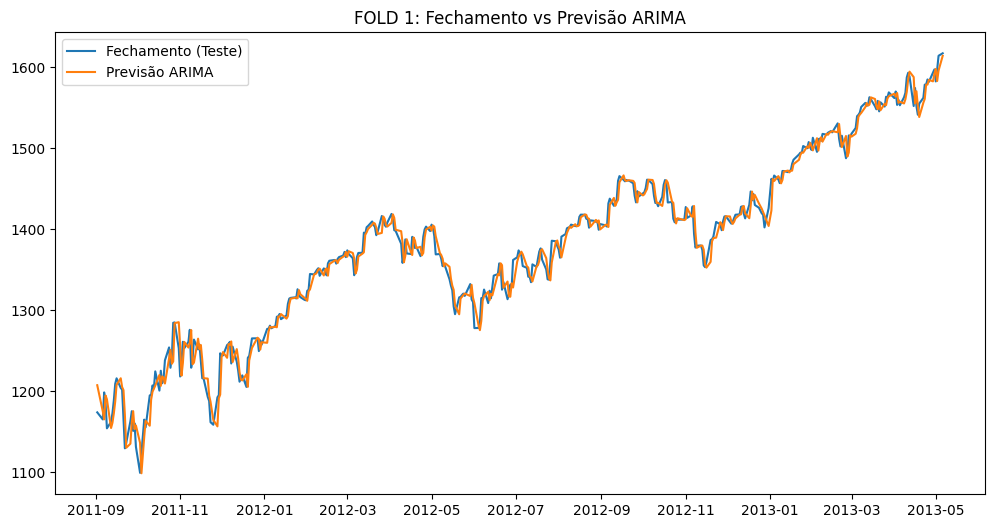

RMSE: 13.67
Lucro Total: 263.40
Percentual de operações vencedoras: 56.25%
Percentual de operações perdedoras: 43.75%
Taxa de acerto (comprar): 56.25%

--- FOLD 2 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


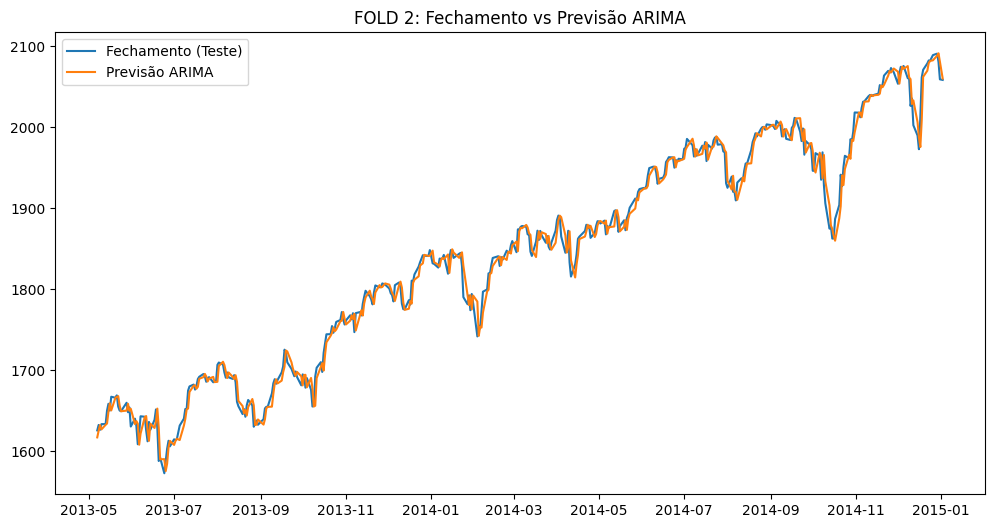

RMSE: 12.94
Lucro Total: 98.78
Percentual de operações vencedoras: 55.35%
Percentual de operações perdedoras: 44.03%
Taxa de acerto (comprar): 55.35%

--- FOLD 3 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


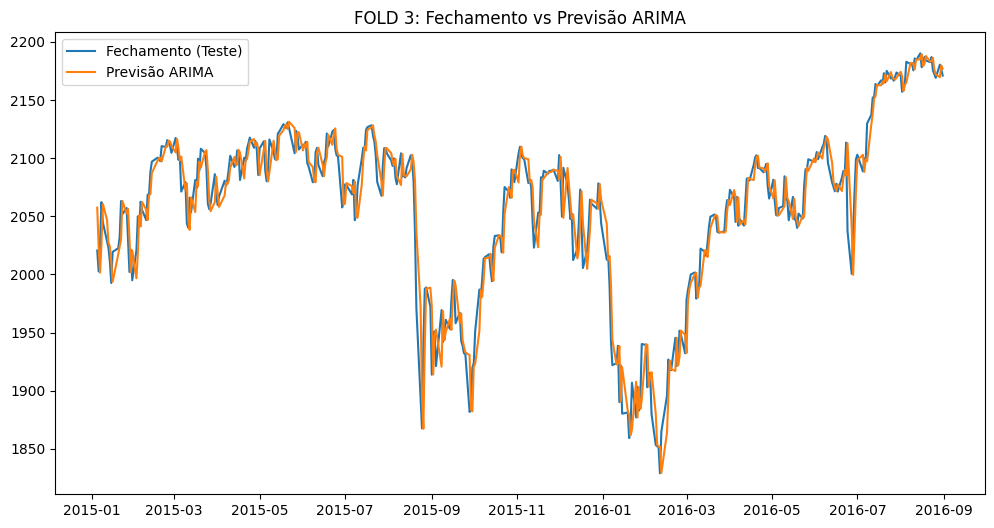

RMSE: 19.08
Lucro Total: 160.98
Percentual de operações vencedoras: 46.24%
Percentual de operações perdedoras: 53.18%
Taxa de acerto (comprar): 46.24%

--- FOLD 4 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


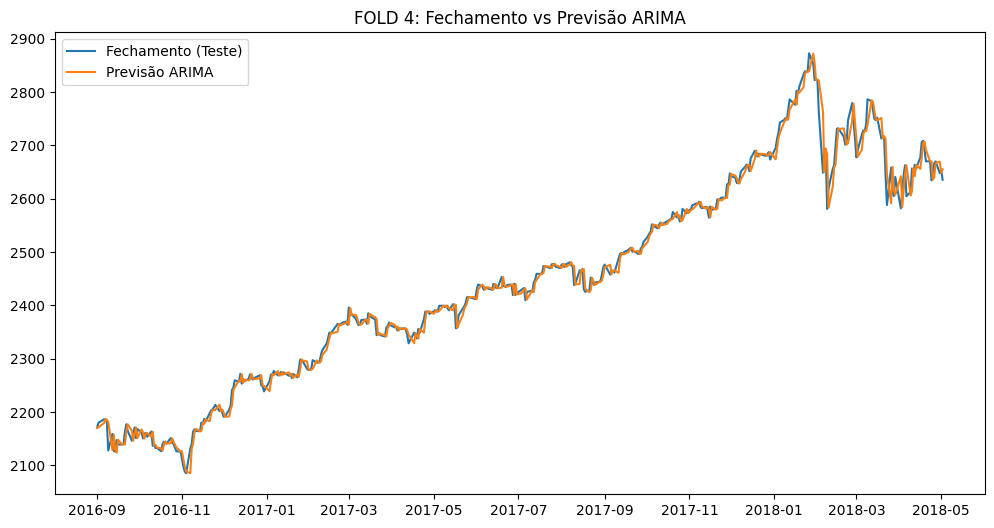

RMSE: 17.52
Lucro Total: 590.50
Percentual de operações vencedoras: 57.89%
Percentual de operações perdedoras: 41.45%
Taxa de acerto (comprar): 57.89%

--- FOLD 5 ---


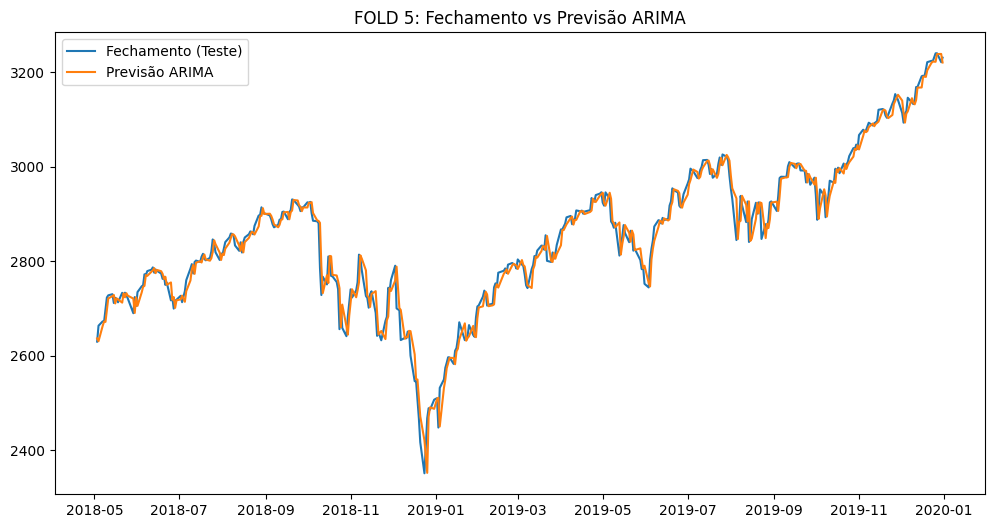

RMSE: 24.43
Lucro Total: -78.60
Percentual de operações vencedoras: 55.00%
Percentual de operações perdedoras: 45.00%
Taxa de acerto (comprar): 55.00%

=== RESULTADOS FINAIS APÓS 5 FOLDS ===
Média RMSE: 17.53
Média de Lucro Total: 207.01


In [ ]:
#@title 10. Resultados agregados

print(f"\n=== RESULTADOS FINAIS APÓS {tscv.n_splits} FOLDS ===")
print(f'Média RMSE: {np.mean(rmse_scores):.2f}')
print(f'Média de Lucro Total: {np.mean(lucros_finais):.2f}')

## **SARIMA**

# **Teste 1**

In [ ]:
#@title 1. Leitura e preparação dos dados
data_path = Path('/content/SP500.csv')
sp500 = pd.read_csv(data_path, parse_dates=['Date'])
sp500.sort_values('Date', inplace=True)
sp500.set_index('Date', inplace=True)
sp500 = sp500.dropna(subset=['Close'])
close_prices = sp500['Close'].dropna()

In [ ]:
#@title 2. Divisão treino/teste
split = int(len(close_prices) * 0.8)
train = close_prices[:split].dropna()
test = close_prices[split:].dropna()  # Usando 20% dos dados para teste

In [ ]:
#@title 3. Previsão rolling forecast (walk-forward)
history = list(train)
predictions = []
for t in range(len(test)):
    model = SARIMAX(history,
                    order=(1,1,1),
                    seasonal_order=(1,1,1,5),  # Alterado para sazonalidade semanal
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False,
                         maxiter=200,  # Aumentado número de iterações
                         method='nm',   # Método Nelder-Mead, mais robusto
                         optim_score='harvey')
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])
predictions = pd.Series(predictions, index=test.index)

# Checagem de NaNs para depuração
print(f'NaNs em predictions: {predictions.isna().sum()}')
print(f'NaNs em test: {test.isna().sum()}')

In [ ]:
#@title 4. Geração de sinais de trading no teste
signals = []
for i in range(len(test)):
    prev_real = test.iloc[i-1] if i > 0 else train.iloc[-1]
    threshold = 0.001  # 0.1%
    if predictions.iloc[i] > prev_real * (1 + threshold):
        signals.append('buy')
    elif predictions.iloc[i] < prev_real * (1 - threshold):
        signals.append('sell')
    else:
        signals.append('hold')
test_df = pd.DataFrame({'Close': test, 'Forecast': predictions, 'Signal': signals}, index=test.index)

In [ ]:
#@title 5. Simulação de backtesting no teste
capital = 10000
position = 0
entry_price = 0
profits = []
trades = []
stop_loss = 0.02  # 2%
take_profit = 0.03  # 3%
for i in range(len(test_df)):
    signal = test_df['Signal'].iloc[i]
    price = test_df['Close'].iloc[i]
    if signal == 'buy' and position == 0:
        position = 1
        entry_price = price
        trades.append('buy')
    elif signal == 'sell' and position == 1:
        profit = price - entry_price
        capital += profit
        profits.append(profit)
        position = 0
        trades.append('sell')
    else:
        trades.append('hold')
    if position == 1:
        # Verificar stop loss
        if price <= entry_price * (1 - stop_loss):
            profit = entry_price * (1 - stop_loss) - entry_price
            capital += profit
            profits.append(profit)
            position = 0
            trades.append('stop_loss')
        # Verificar take profit
        elif price >= entry_price * (1 + take_profit):
            profit = entry_price * (1 + take_profit) - entry_price
            capital += profit
            profits.append(profit)
            position = 0
            trades.append('take_profit')
test_df['Trade'] = trades

In [ ]:
#@title 6. Cálculo das métricas no teste
num_trades = trades.count('buy')
num_wins = sum([1 for p in profits if p > 0])
num_losses = sum([1 for p in profits if p <= 0])
percent_wins = num_wins / num_trades * 100 if num_trades > 0 else 0
percent_losses = num_losses / num_trades * 100 if num_trades > 0 else 0
lucro_total = sum(profits)
taxa_acerto_buy = num_wins / num_trades * 100 if num_trades > 0 else 0

In [ ]:
#@title 7. Relatórios visuais
plt.figure(figsize=(12,6))
plt.plot(test_df['Close'], label='Fechamento (Teste)')
plt.plot(test_df['Forecast'], label='Previsão SARIMA')
plt.legend()
plt.title('Fechamento e Previsão SARIMA (Período de Teste)')
plt.show()

# Cálculo do RMSE no teste
rmse = np.sqrt(mean_squared_error(test_df['Close'], test_df['Forecast']))
print(f'RMSE (Root Mean Squared Error) no teste: {rmse:.2f}')

print(f'Percentual de operações vencedoras: {percent_wins:.2f}%')
print(f'Percentual de operações perdedoras: {percent_losses:.2f}%')
print(f'Lucro Total: {lucro_total:.2f}')
print(f'Taxa de acerto (comprar): {taxa_acerto_buy:.2f}%')

# **Teste 2**

In [ ]:
#@title 1. Leitura e preparação dos dados
sp500 = pd.read_csv('/content/SP500.csv', parse_dates=['Date'])
sp500.sort_values('Date', inplace=True)
sp500.set_index('Date', inplace=True)
close_prices = sp500['Close']

In [ ]:
#@title 2. Divisão treino/teste
split = int(len(close_prices) * 0.8)
train = close_prices[:split]
test = close_prices[split:]

In [ ]:
#@title 3. Ajuste do modelo ARIMA apenas no treino
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

In [ ]:
#@title 4. Previsão para o período de teste
forecast = model_fit.forecast(steps=len(test))

In [ ]:
#@title 5. Geração de sinais de trading no teste
signals = []
for i in range(len(test)):
    if forecast.iloc[i] > test.iloc[i-1] if i > 0 else train.iloc[-1]:
        signals.append('buy')
    elif forecast.iloc[i] < test.iloc[i-1] if i > 0 else train.iloc[-1]:
        signals.append('sell')
    else:
        signals.append('hold')
test_df = pd.DataFrame({'Close': test, 'Forecast': forecast, 'Signal': signals}, index=test.index)

In [ ]:
#@title 6. Simulação de backtesting no teste
capital = 10000
position = 0
entry_price = 0
profits = []
trades = []
for i in range(len(test_df)):
    signal = test_df['Signal'].iloc[i]
    price = test_df['Close'].iloc[i]
    if signal == 'buy' and position == 0:
        position = 1
        entry_price = price
        trades.append('buy')
    elif signal == 'sell' and position == 1:
        profit = price - entry_price
        capital += profit
        profits.append(profit)
        position = 0
        trades.append('sell')
    else:
        trades.append('hold')
test_df['Trade'] = trades

In [ ]:
#@title 7. Cálculo das métricas no teste
num_trades = trades.count('buy')
num_wins = sum([1 for p in profits if p > 0])
num_losses = sum([1 for p in profits if p <= 0])
percent_wins = num_wins / num_trades * 100 if num_trades > 0 else 0
percent_losses = num_losses / num_trades * 100 if num_trades > 0 else 0
lucro_total = sum(profits)
taxa_acerto_buy = num_wins / num_trades * 100 if num_trades > 0 else 0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

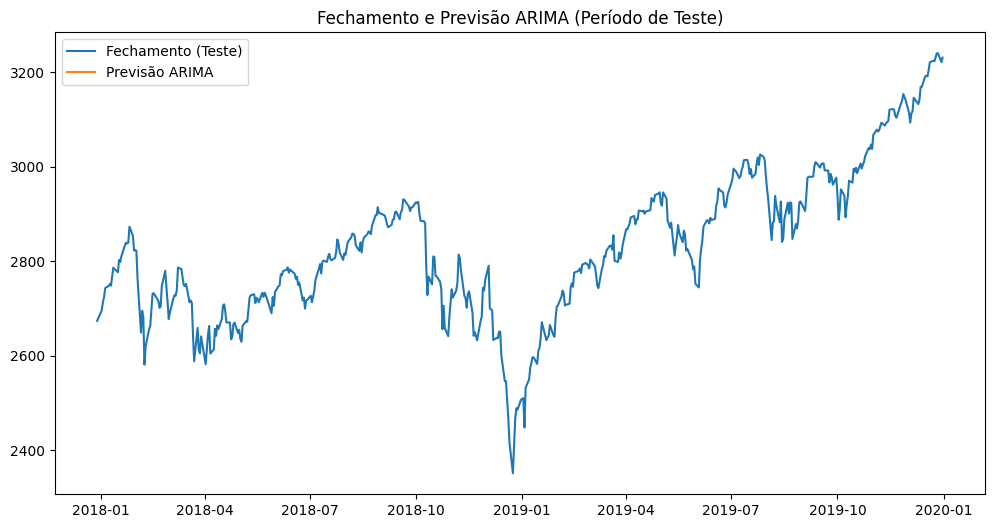

ValueError: Input contains NaN.

In [ ]:
#@title 8. Relatórios visuais
plt.figure(figsize=(12,6))
plt.plot(test_df['Close'], label='Fechamento (Teste)')
plt.plot(test_df['Forecast'], label='Previsão ARIMA')
plt.legend()
plt.title('Fechamento e Previsão ARIMA (Período de Teste)')
plt.show()

# Cálculo do RMSE no teste
rmse = np.sqrt(mean_squared_error(test_df['Close'], test_df['Forecast']))
print(f'RMSE (Root Mean Squared Error) no teste: {rmse:.2f}')

print(f'Percentual de operações vencedoras: {percent_wins:.2f}%')
print(f'Percentual de operações perdedoras: {percent_losses:.2f}%')
print(f'Lucro Total: {lucro_total:.2f}')
print(f'Taxa de acerto (comprar): {taxa_acerto_buy:.2f}%')